In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import re
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
#from nltk.corpus import stopwords
import string
import operator
import seaborn as sns
%matplotlib inline

In [2]:
with open("../out/juicers.json", "r") as f:
    allJuicers = json.load(f)

priceListByBrand = {}
rankListByBrand = {}
juicersByAsin = {}
for cat, juicers in allJuicers.items():
    for juicer in juicers:
        asin = list(juicer.keys())[0]
        val = list(juicer.values())[0]
        val.update({"category":cat})
        if any(x in val['title'].lower() for x in ['juice','juicer']):
            juicersByAsin.update({asin: val})
        else:
            continue
        brand = val['brand']
        try:
            if brand.lower() == 'breville juicer':
                brand = 'breville'
        except:
            continue

        try:
            if brand.lower() == 'omega juicers':
                brand = 'omega'
        except:
            continue
        try:
            priceListByBrand.setdefault(brand, []).append(float(val['price'][1:]))
        except:
            pass

        try:
            if not val['sales_rank'] == 'None':
                rankListByBrand.setdefault(brand, []).append(int(val['sales_rank']))
        except:
            pass

df_all = pd.DataFrame(juicersByAsin)

df_all.head()

,B00004R93U,B00004R93V,B00004S8FH,B00004S8FI,B00004S8FJ,B00004SC51,B00004X139,B00005MF9O,B00005OTY9,B00005V3W4,...,B072KSZ8KD,B072NBBHWJ,B072ND9V5C,B072P2YQXD,B072SV42RJ,B072TZ3F78,B072VL3FXH,B072WPDGDN,B073345HMW,B0739LW3XS
brand,Juiceman,Juiceman,Waring,Waring,Waring,BLACK+DECKER,Hamilton Beach,BLACK+DECKER,Juiceman,Hamilton Beach,...,Robot Coupe,XmiPbs,Robot Coupe,Pawaca,Frigidairenire,iPstyle,Decdeal,Raylans,GTT,LOVSHARE
category,centrifugal,centrifugal,centrifugal,citrus,citrus,citrus,centrifugal,citrus,centrifugal,centrifugal,...,centrifugal,citrus,centrifugal,masticating,centrifugal,centrifugal,centrifugal,centrifugal,centrifugal,centrifugal
color,Off-White,White,White,Quite White,Stainless Steel,None,White,Blue,White,None,...,None,Pink,None,Green,Purple,Green,None,Blue,Purple,None
features,[Peppy 1/4-horsepower motor quickly juices mos...,[Powerful 1/2-horsepower motor quickly juices ...,[Converts all noncitrus fruits and vegetables ...,"[Juices all citrus fruits, from limes to grape...","[Juices all citrus fruits, from limes to grape...","[Large 1 liter (34 ounce) pitcher, Adjustable ...",[This Hamilton Beach HealthSmart Juice Extract...,"[Electric juicer, beverage stirrer, and servin...",[Automatic fruit and vegetable juicer for freq...,[Extracts juice from raw fruits and vegetables...,...,[],"[Mini juicer cup in size, portable and great f...",[],"[Juicer Cup, Battery Powered Electric Juice Bl...",[SUPPLY THE NUTRITION: Supply the nutrition th...,[Portable Personal Blender Multifunctional : s...,[One machine with multiple function (one in al...,"[Food grade materials, safe and non-toxic, Lig...",[♨MATERIAL ♨ Made of eco-friendly & food-grade...,[Dimension: 432 x 444 x 350mm / 17 x 17.5 x 13...
price,$158.98,$79.95,$360.00,None,$149.99,$59.32,$42.38,$48.99,None,$41.89,...,"$1,598.10",$29.99,"$1,993.95",$22.29,$15.99,$27.99,$119.99,$18.53,$19.99,$633.99


In [3]:
df_all = df_all.T
df_all.head()

,brand,category,color,features,price,sales_rank,title
B00004R93U,Juiceman,centrifugal,Off-White,[Peppy 1/4-horsepower motor quickly juices mos...,$158.98,1006304,Juiceman Jr. Elite Pro JM211 Juice Extractor
B00004R93V,Juiceman,centrifugal,White,[Powerful 1/2-horsepower motor quickly juices ...,$79.95,778846,The Juiceman Electronic Professional Series 41...
B00004S8FH,Waring,centrifugal,White,[Converts all noncitrus fruits and vegetables ...,$360.00,227195,"Waring PJE401 Juice Extractor, Quite White and..."
B00004S8FI,Waring,citrus,Quite White,"[Juices all citrus fruits, from limes to grape...",None,254788,"Waring PCJ201 Citrus Juicer, Quite White"
B00004S8FJ,Waring,citrus,Stainless Steel,"[Juices all citrus fruits, from limes to grape...",$149.99,231125,"Waring PCJ218 Citrus Juicer, Stainless Steel"


In [4]:
df_all.isnull().sum()

brand           7
category        0
color         178
features        0
price          49
sales_rank      0
title           0
dtype: int64

In [5]:
(df_all=='None').sum()

brand           0
category        0
color           1
features        0
price           0
sales_rank    252
title           0
dtype: int64

In [6]:
df_all[df_all == 'None'] = float('NaN')

In [7]:
(df_all=='None').sum()

brand         0
category      0
color         0
features      0
price         0
sales_rank    0
title         0
dtype: int64

In [8]:
df_all.isnull().sum()

brand           7
category        0
color         179
features        0
price          49
sales_rank    252
title           0
dtype: int64

In [9]:
print(df_all.columns)
print(df_all.shape)

Index(['brand', 'category', 'color', 'features', 'price', 'sales_rank',
       'title'],
      dtype='object')
(1017, 7)


In [10]:
df_all.dropna(inplace=True)

In [11]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, B00004R93U to B072WPDGDN
Data columns (total 7 columns):
brand         636 non-null object
category      636 non-null object
color         636 non-null object
features      636 non-null object
price         636 non-null object
sales_rank    636 non-null object
title         636 non-null object
dtypes: object(7)
memory usage: 39.8+ KB


In [12]:
df_all.dtypes

brand         object
category      object
color         object
features      object
price         object
sales_rank    object
title         object
dtype: object

#### Convert some columns to lowercase string

In [13]:
strlist = ['brand', 'category', 'color', 'price', 'title']
df_all[strlist] = df_all[strlist].applymap(lambda x: x.lower())
df_all[strlist].head()

,brand,category,color,price,title
B00004R93U,juiceman,centrifugal,off-white,$158.98,juiceman jr. elite pro jm211 juice extractor
B00004R93V,juiceman,centrifugal,white,$79.95,the juiceman electronic professional series 41...
B00004S8FH,waring,centrifugal,white,$360.00,"waring pje401 juice extractor, quite white and..."
B00004S8FJ,waring,citrus,stainless steel,$149.99,"waring pcj218 citrus juicer, stainless steel"
B00004X139,hamilton beach,centrifugal,white,$42.38,"juice extractor,healthsmart"


#### Remove \$ sign and cast to float

In [14]:
def getPrice(x):
    x = x.replace(',','.')
    res = re.findall('\d+.\d+', x)
    if res:
        return res[0]
    else:
        return float('NaN')

df_all['price'] = df_all['price'].apply(getPrice)

In [15]:
df_all['price'].isnull().sum()

15

In [16]:
df_all.dropna(inplace=True)

In [17]:
df_all['price'] = df_all['price'].astype(float)

#### Cast sales_rank to int

In [18]:
df_all['sales_rank'] = df_all['sales_rank'].astype(int)

In [19]:
df_all.shape

(621, 7)

In [20]:
df_all['features'].iloc[0]

['Peppy 1/4-horsepower motor quickly juices most fruits and vegetables',
 'Makes tasty, nutritious, and additive-free juice blends',
 'Stainless steel blade, basket with micro-mesh strainer to screen out pulp',
 'Medium-capacity pulp receptacle for continuous juicing',
 'Two-speed control for soft or hard produce']

#### Unique values per color

In [21]:
for col in df_all.columns.tolist():
    try:
        print(col, df_all[col].unique().shape[0])
    except:
        continue

brand 250
category 3
color 127
price 461
sales_rank 621
title 616


In [22]:
df_all.head()

,brand,category,color,features,price,sales_rank,title
B00004R93U,juiceman,centrifugal,off-white,[Peppy 1/4-horsepower motor quickly juices mos...,158.98,1006304,juiceman jr. elite pro jm211 juice extractor
B00004R93V,juiceman,centrifugal,white,[Powerful 1/2-horsepower motor quickly juices ...,79.95,778846,the juiceman electronic professional series 41...
B00004S8FH,waring,centrifugal,white,[Converts all noncitrus fruits and vegetables ...,360.00,227195,"waring pje401 juice extractor, quite white and..."
B00004S8FJ,waring,citrus,stainless steel,"[Juices all citrus fruits, from limes to grape...",149.99,231125,"waring pcj218 citrus juicer, stainless steel"
B00004X139,hamilton beach,centrifugal,white,[This Hamilton Beach HealthSmart Juice Extract...,42.38,919971,"juice extractor,healthsmart"


In [23]:
df_all['color'].unique()

array(['off-white', 'white', 'stainless steel', 'blue', 'gray',
       'quite white', 'brushed stainless steel', 'chrome', 'yellow',
       'black / silver', 'ivory', 'black', 'black & silver', 'silver',
       'ivory or black', 'stainless', 'almond', 'pink white', 'raspberry',
       'light green', 'steel', 'orange', 'silver black', 'null',
       'sless/steel', 'red or white', 'chrome plated', 'pearl white',
       'green', 'red', 'chrome colored', 'noble silver', 'green yellow',
       'polished aluminum', 'polished stainless', 'stainless steel color',
       'purple', 'gray & black', 'je98xl w/dvd', 'clear',
       'black & stainless steel', 'silver-black', 'silver/black',
       'silver, grey', 'silver grey', 'red/black', 'black/stailess steel',
       'not applicable', 'red & black', 'black/ stainless steel',
       'stainless steel/black', 'silver, black', 'metallic',
       'silver & black', 'balck', 'silver (plastic)', 'pearl red',
       'gold black', 'orange/green', 'silver 

In [24]:
df_all['brand'] = df_all['brand'].replace("breville juicer", "breville")
df_all['brand'] = df_all['brand'].replace("omega juicers", "omega")
df_all.head()

,brand,category,color,features,price,sales_rank,title
B00004R93U,juiceman,centrifugal,off-white,[Peppy 1/4-horsepower motor quickly juices mos...,158.98,1006304,juiceman jr. elite pro jm211 juice extractor
B00004R93V,juiceman,centrifugal,white,[Powerful 1/2-horsepower motor quickly juices ...,79.95,778846,the juiceman electronic professional series 41...
B00004S8FH,waring,centrifugal,white,[Converts all noncitrus fruits and vegetables ...,360.00,227195,"waring pje401 juice extractor, quite white and..."
B00004S8FJ,waring,citrus,stainless steel,"[Juices all citrus fruits, from limes to grape...",149.99,231125,"waring pcj218 citrus juicer, stainless steel"
B00004X139,hamilton beach,centrifugal,white,[This Hamilton Beach HealthSmart Juice Extract...,42.38,919971,"juice extractor,healthsmart"


In [25]:
def clean_price(s):
    s = re.findall("\d+\.\d+",s)
    if s:
        return s[0]

In [26]:
df_all.pivot_table(index='category', values='price', aggfunc=np.mean)

,price
category,
centrifugal,171.656995
citrus,96.871509
masticating,284.749667


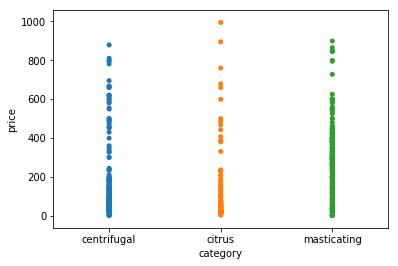

In [27]:
sns.stripplot(x='category', y='price', data=df_all)

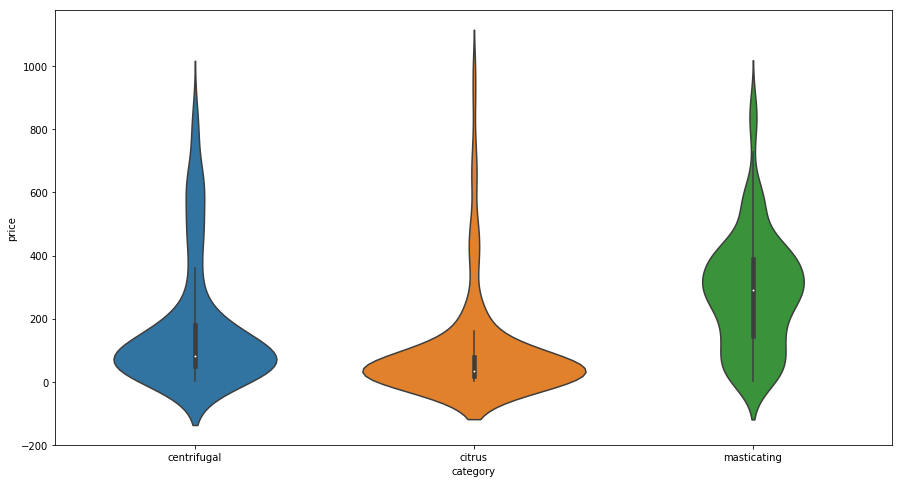

In [29]:
plt.figure(figsize=(15,8))
sns.violinplot(x='category', y='price', data=df_all)

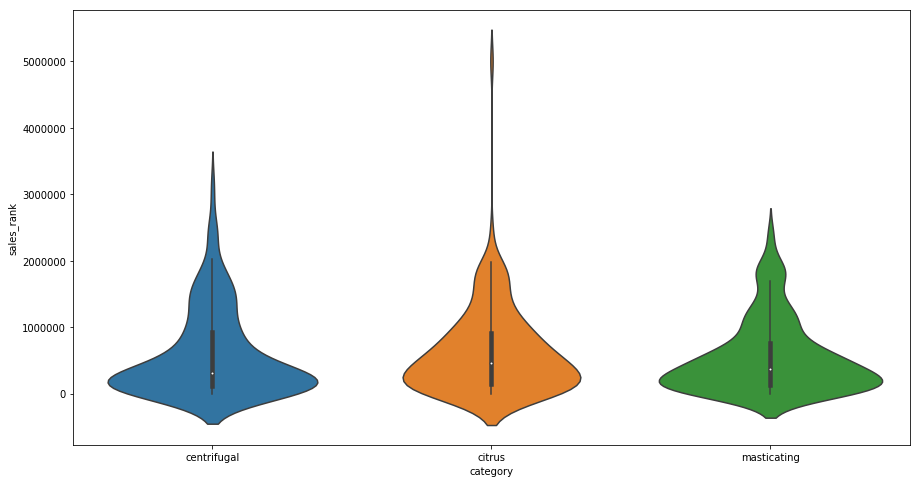

In [30]:
plt.figure(figsize=(15,8))
sns.violinplot(x='category', y='sales_rank', data=df_all)

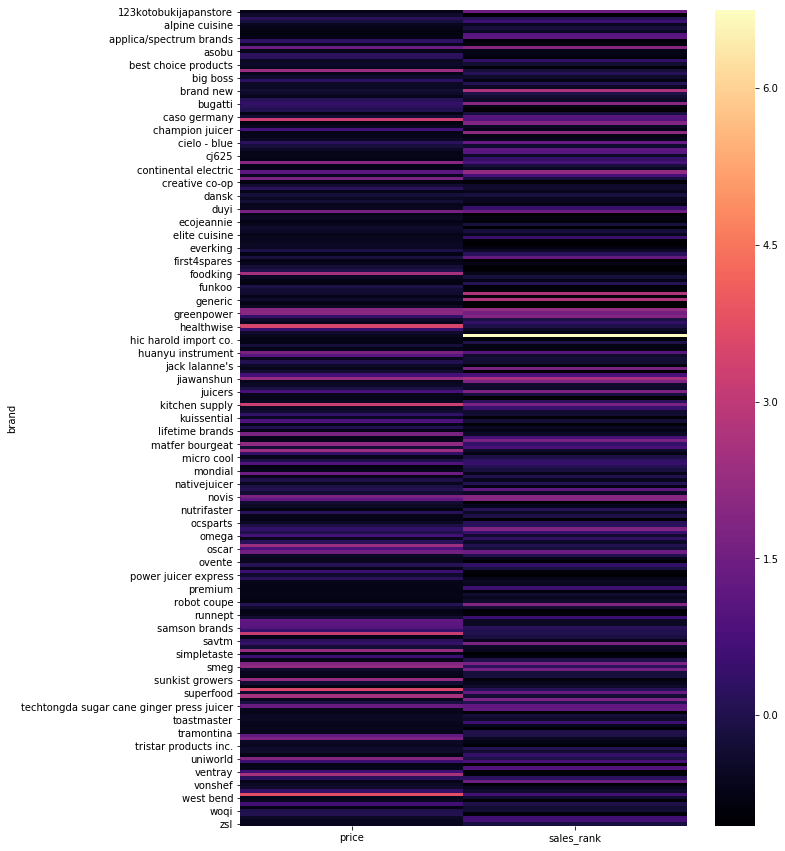

In [31]:
plt.figure(figsize=(10,15))
sns.heatmap(df_all.pivot_table(index='brand', values=['price', 'sales_rank'], aggfunc=np.mean).apply(preprocessing.scale), cmap='magma')

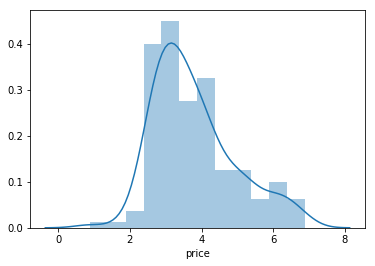

In [32]:
sns.distplot(df_all[df_all['category']=='citrus']['price'].apply(np.log))

In [33]:
df_all.isnull().sum()

brand         0
category      0
color         0
features      0
price         0
sales_rank    0
title         0
dtype: int64

In [34]:
#feature engineering on the category column
df_all['category'][df_all['category'] == 'citrus'] = 1
df_all['category'][df_all['category'] == 'centrifugal'] = 2
df_all['category'][df_all['category'] == 'masticating'] = 3
df_all.head()

/usr/lib/python3/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,brand,category,color,features,price,sales_rank,title
B00004R93U,juiceman,2,off-white,[Peppy 1/4-horsepower motor quickly juices mos...,158.98,1006304,juiceman jr. elite pro jm211 juice extractor
B00004R93V,juiceman,2,white,[Powerful 1/2-horsepower motor quickly juices ...,79.95,778846,the juiceman electronic professional series 41...
B00004S8FH,waring,2,white,[Converts all noncitrus fruits and vegetables ...,360.00,227195,"waring pje401 juice extractor, quite white and..."
B00004S8FJ,waring,1,stainless steel,"[Juices all citrus fruits, from limes to grape...",149.99,231125,"waring pcj218 citrus juicer, stainless steel"
B00004X139,hamilton beach,2,white,[This Hamilton Beach HealthSmart Juice Extract...,42.38,919971,"juice extractor,healthsmart"


In [35]:
df_all['sales_rank'] = df_all['sales_rank'].astype(int)

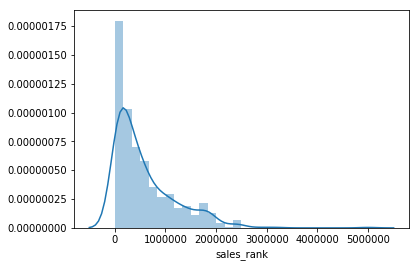

In [36]:
sns.distplot(df_all['sales_rank'])

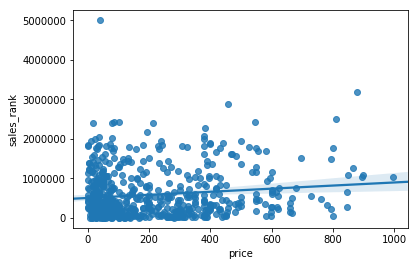

In [37]:
sns.regplot(x='price', y='sales_rank', data=df_all)

In [40]:
pd.options.mode.chained_assisd cxngnment = None
#df_all['sales_rank'] /= 100

In [37]:
df_all['cat_rank'] = pd.cut(df_all['sales_rank'], 5)
rank_vs_price = df_all.pivot_table(index='cat_rank', values='price', aggfunc=np.mean)

In [443]:
rank_vs_price

,price
cat_rank,
"(-4685.124, 1001143.8]",194.928350
"(1001143.8, 2001968.6]",278.634828
"(2001968.6, 3002793.4]",259.666923
"(3002793.4, 4003618.2]",879.000000
"(4003618.2, 5004443.0]",40.000000


In [444]:
def rank_feature(rank):
    if rank < 1001143.8:
        return 0
    if rank >= 1001143.8 and rank < 2001968.6:
        return 1
    if rank >= 2001968.6 and rank < 3002793.4:
        return 2
    if rank >= 3002793.4 and rank < 4003618.2:
        return 3
    if rank >= 4003618.2 and rank < 5004443.0:
        return 4

df_all['new_rank'] = df_all['sales_rank'].apply(rank_feature)
df_all.drop(['sales_rank', 'cat_rank'], axis=1, inplace=True)
df_all.head()

,brand,category,color,features,price,title,new_rank
B00004R93U,juiceman,2,Off-White,[Peppy 1/4-horsepower motor quickly juices mos...,158.98,Juiceman Jr. Elite Pro JM211 Juice Extractor,1.0
B00004R93V,juiceman,2,White,[Powerful 1/2-horsepower motor quickly juices ...,79.95,The Juiceman Electronic Professional Series 41...,0.0
B00004S8FH,waring,2,White,[Converts all noncitrus fruits and vegetables ...,360.00,"Waring PJE401 Juice Extractor, Quite White and...",0.0
B00004S8FJ,waring,1,Stainless Steel,"[Juices all citrus fruits, from limes to grape...",149.99,"Waring PCJ218 Citrus Juicer, Stainless Steel",0.0
B00004X139,hamilton beach,2,White,[This Hamilton Beach HealthSmart Juice Extract...,42.38,"Juice Extractor,Healthsmart",0.0


In [455]:
df_all.pivot_table(index='brand', values='price', aggfunc=np.mean).sort_values(by='price', ascending=False)
df_all = df_all[~df_all['price'].isnull()]
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 622 entries, B00004R93U to B072WPDGDN
Data columns (total 7 columns):
brand       622 non-null object
category    622 non-null object
color       622 non-null object
features    622 non-null object
price       622 non-null float64
title       622 non-null object
new_rank    621 non-null float64
dtypes: float64(2), object(5)
memory usage: 38.9+ KB


In [458]:
brandlist = df_all['brand'].unique()
d = {}
for i, brand in enumerate(brandlist):
    d.update({brand:i})
    
df_all['brand'] = df_all['brand'].map(d)

In [460]:
df_all['color'] = df_all['color'].str.lower()

In [461]:
df_all['color'] = df_all['color'].replace(['stainless', 'steel', 'brushed stainless steel'], 'stainless steel')

In [462]:
colorlist = df_all['color'].unique()
d = {}
for i, color in enumerate(colorlist):
    d.update({color:i})
    
df_all['color'] = df_all['color'].map(d)

In [473]:
def featuring(lis):
    for l in lis:
        if "nut" in l:
            return 1
    else:
        return 0

df_all['features weight'] = df_all['features'].apply(featuring)

In [474]:
df_all.dropna(inplace=True)

In [479]:
df_train = df_all[['brand', 'category', 'color', 'new_rank', 'features weight']]
df_train
#X = np.array(df_all[['brand', 'category', 'color', 'new_rank', 'features weight']])

,brand,category,color,new_rank,features weight
B00004R93U,0,2,0,1.0,1
B00004R93V,0,2,1,0.0,1
B00004S8FH,1,2,1,0.0,0
B00004S8FJ,1,1,2,0.0,0
B00004X139,2,2,1,0.0,0
B00005MF9O,3,1,3,1.0,0
B00006IUZK,4,1,1,0.0,0
B00009ENKU,5,3,1,0.0,0
B00009KO85,1,2,2,0.0,0
B0000DDVN4,6,2,4,0.0,0


In [476]:
y = np.array(df_all['price'])

In [477]:
lr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)
model = lr.fit(X_train, y_train)
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.203840122703
